Causal representation learning (CRL) does not tell us what each latent factors actually mean. In this notebook, we search for a benchmark that is highly correlated with the latent factor, which allows for interpretability.



In [1]:
# Change the directory to the Tables folder
TABLE_DIR = '../Tables/'
FIG_DIR = '../Figures/'
FIG_DIR_0125 = '../Figures/new/[0, 1, 2, 5]/'

In [3]:
import os
FIG_DIR_0125_LOGISTIC = FIG_DIR_0125 + 'logistic_fit/'
os.makedirs(FIG_DIR_0125_LOGISTIC, exist_ok=True)

In [4]:
import numpy as np
import pandas as pd

We look at the latent factor $z_3$, which by definition is some weighted average of the observed benchmark performance. Moreover, the weights are already learned by LiNGCReL.

In [5]:
comparison_vector = pd.Series([0.06, 0.74, -0.05, 0.27, 0.26, 0.55])
cols_to_transform_new = ['IFEval', 'BBH', 'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO']

We look at the six benchmarks used in the old version of open LLM leaderboard. To allow comparison, we extract. data of the models that appear in both the old version and the new version.

In [6]:
def marge_on_fullname(df, df_new, cols_to_transform_new = cols_to_transform_new, weights = comparison_vector.values):
  # Convert 'fullname' columns to lowercase for case-insensitive matching
  df = df.dropna()
  df['fullname'] = df['fullname'].str.lower()
  df_new['fullname'] = df_new['fullname'].str.lower()

  # Find common fullnames
  common_fullnames = set(df['fullname']).intersection(set(df_new['fullname']))

  # Filter df to include only rows with common fullnames
  sub_df = df[df['fullname'].isin(common_fullnames)]

  # Merge df_new into sub_df based on 'fullname'
  sub_df = pd.merge(sub_df, df_new[['fullname'] + cols_to_transform_new], on='fullname', how='left')

  weighted_values = sub_df[cols_to_transform_new].mul(weights)
  # Sum the weighted values for each row
  sum_of_weighted_values = weighted_values.sum(axis=1)

  # Sum of the weights
  sum_of_weights = np.sum(weights)

  # Calculate weighted average
  weighted_average = sum_of_weighted_values / sum_of_weights

  return sub_df, weighted_average

In [9]:
%%capture
# Old version
df = pd.read_parquet("hf://datasets/open-llm-leaderboard-old/contents/data/train-00000-of-00001-96886cb34a7bc800.parquet")

In [10]:
# New version
df_new = pd.read_parquet("hf://datasets/open-llm-leaderboard/contents/data/train-00000-of-00001.parquet")

In [11]:
%%capture
sub_df, avg = marge_on_fullname(df, df_new)

In [12]:
len(sub_df)

471

In [13]:
cols_to_transform = ['ARC', 'HellaSwag', 'MMLU', 'TruthfulQA', 'Winogrande', 'GSM8K'] # Benchmarks in the old version

We first try to run OLS with X = latent factor $z_3$ and Y = old benchmark, and see how well it fits the data.

In [14]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

for col in cols_to_transform:
    # Prepare the data for OLS regression
    X = avg.values.reshape(-1, 1)
    X = sm.add_constant(X)  # Add a constant term to the independent variables
    y = sub_df[col]

    # Fit the OLS model
    model = sm.OLS(y, X).fit()

    # Extract the coefficients (excluding the constant)
    coefficients = model.params[1:] # Index 0 is the constant

    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ARC   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     935.5
Date:                Sun, 23 Feb 2025   Prob (F-statistic):          8.95e-114
Time:                        18:40:46   Log-Likelihood:                -1644.7
No. Observations:                 471   AIC:                             3293.
Df Residuals:                     469   BIC:                             3302.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.8754      0.794     46.464      0.0

We then show that better fitting can be obtained by using sigmoid functions.

Column: ARC
Fitted parameters:
  L = 3.8553, U = 27.9368, x0 = 56.4185, k = 0.1830
R-square: 0.7178

Column: HellaSwag
Fitted parameters:
  L = 4.3173, U = 27.3818, x0 = 78.1773, k = 0.2562
R-square: 0.6293

Column: MMLU
Fitted parameters:
  L = 2.3615, U = 48.2912, x0 = 69.2832, k = 0.0796
R-square: 0.8629

Column: TruthfulQA
Fitted parameters:
  L = 2.0587, U = 25.8235, x0 = 44.6684, k = 0.1965
R-square: 0.5211

Column: Winogrande
Fitted parameters:
  L = 3.2137, U = 29.5929, x0 = 73.6420, k = 0.1917
R-square: 0.6209

Column: GSM8K
Fitted parameters:
  L = -133.9019, U = 7850.8633, x0 = 2140.3100, k = 0.0019
R-square: 0.6250



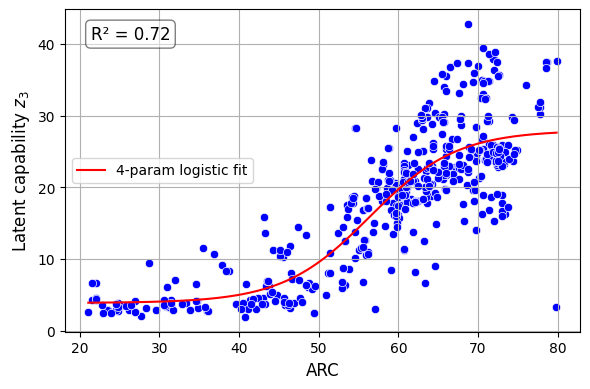

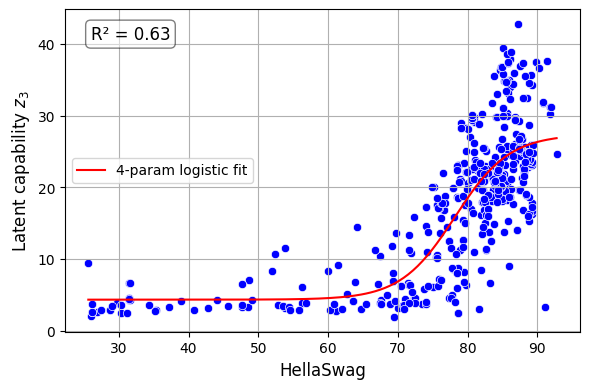

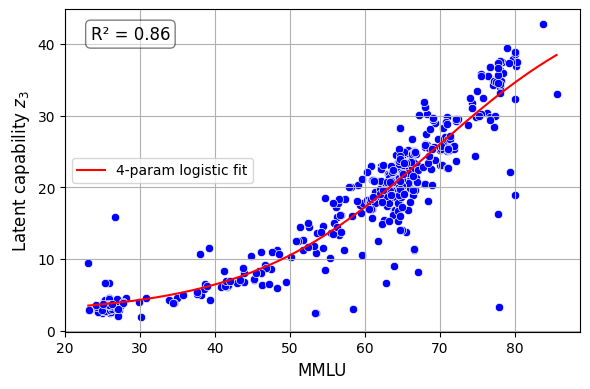

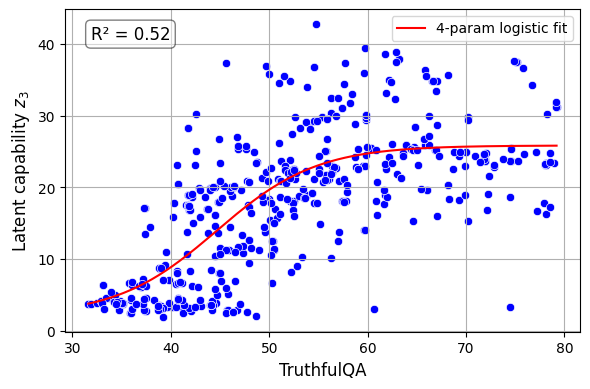

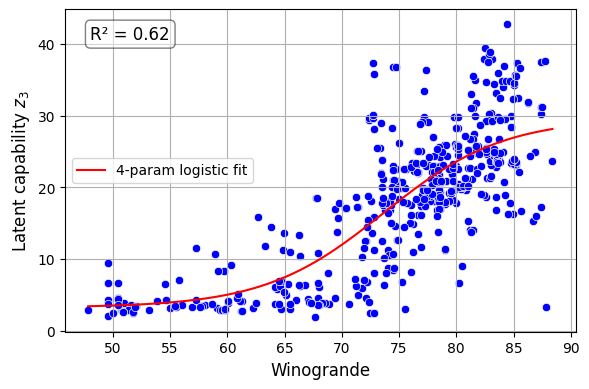

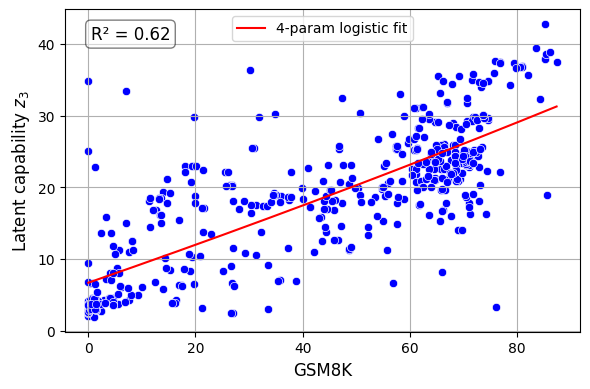

In [25]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns

def logistic_4param(x, L, U, x0, k):
    """
    L:  lower asymptote
    U:  upper asymptote
    x0: x-value of inflection point
    k:  slope parameter
    """
    return L + (U - L) / (1 + np.exp(-k * (x - x0)))

for col in cols_to_transform:
    # Prepare the data
    X = sub_df[col].values        # Convert to NumPy array
    y = avg.values.reshape(-1)    # Flatten to 1D

    # Initial guess for [L, U, x0, k]
    # Adjust these if you have prior knowledge of approximate bounds:
    initial_guess = [0.0, 50.0, 70.0, 0.0]

    # Fit the 4-parameter logistic function
    popt, pcov = curve_fit(logistic_4param, X, y, p0=initial_guess, maxfev=5000)
    L_opt, U_opt, x0_opt, k_opt = popt

    # Generate predictions
    y_pred = logistic_4param(X, L_opt, U_opt, x0_opt, k_opt)

    # Calculate R-square
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    print(f"Column: {col}")
    print(f"Fitted parameters:\n  L = {L_opt:.4f}, U = {U_opt:.4f}, x0 = {x0_opt:.4f}, k = {k_opt:.4f}")
    print(f"R-square: {r2:.4f}\n")

    # Optional: plot the data and the fitted curve
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X, y=y, color="blue")
    # Plot a smooth curve over the data range
    x_range = np.linspace(np.min(X), np.max(X), 200)
    plt.plot(x_range, logistic_4param(x_range, L_opt, U_opt, x0_opt, k_opt),
             color="red", label="4-param logistic fit")
    # Add R-squared text to the plot
    plt.text(0.05, 0.95, f'RÂ² = {r2:.2f}', transform=plt.gca().transAxes,
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    # plt.title(f"4-Parameter Logistic Fit for {col}")
    plt.xlabel(col, fontsize = 12)
    plt.ylabel("Latent capability " + r"$z_3$", fontsize = 12)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_DIR_0125_LOGISTIC + f"logistic_fit_{col}.png", dpi = 300)

We also look at how sigmoid can fit the individual tasks in MMLU. The data is extracted from https://huggingface.co/spaces/CoreyMorris/MMLU-by-task-Leaderboard.

In [19]:
df_mmlu = pd.read_csv(TABLE_DIR + "MMLU-by-task-Leaderboard.csv")

In [21]:
# Get the column names that start with 'mnlu' (case-insensitive)
df_mmlu_cols = [col for col in df_mmlu.columns if col.lower().startswith('mmlu')]

In [23]:
%%capture
sub_df_mmlu, avg_mmlu = marge_on_fullname(df_mmlu, df_new)

<ipython-input-33-7e9c0910ac54>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')
<ipython-input-33-7e9c0910ac54>:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right") # Rotate x-axis labels for readability


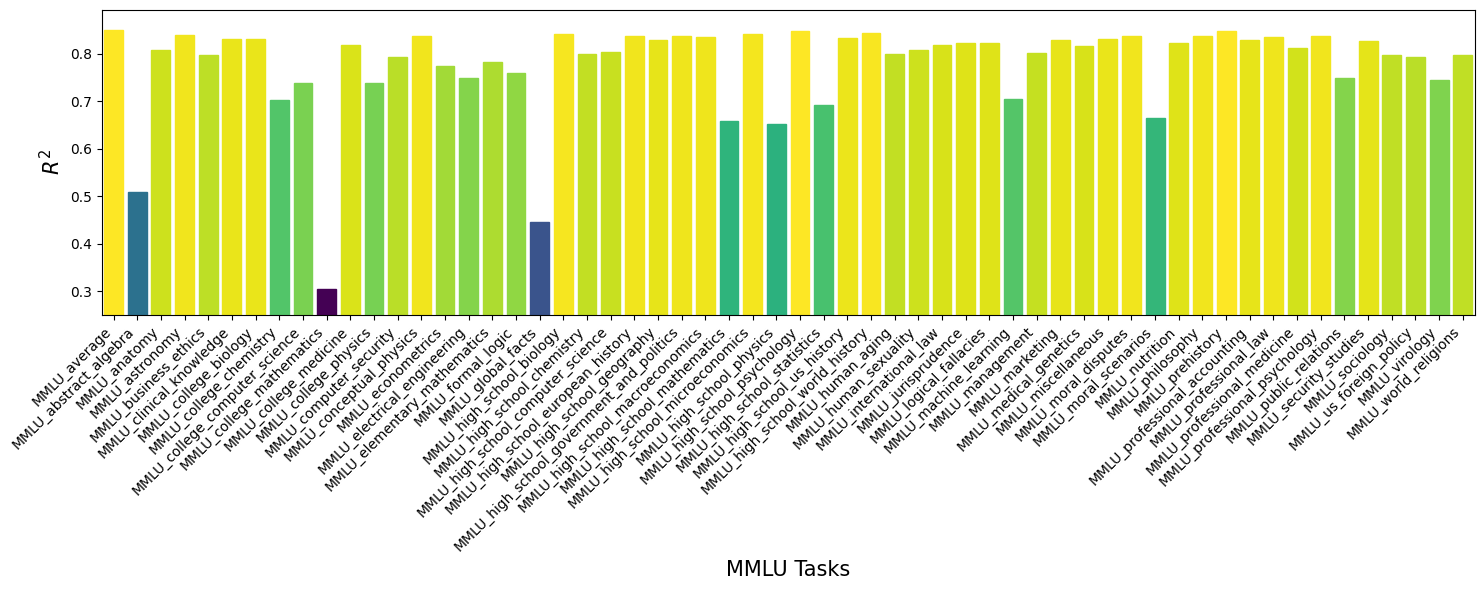

In [33]:
import matplotlib.cm as cm

r2_values = {}

for col in df_mmlu_cols:
    # Prepare the data
    X = sub_df_mmlu[col].values        # Convert to NumPy array
    y = avg_mmlu.values.reshape(-1)    # Flatten to 1D

    # Initial guess for [L, U, x0, k]
    # Adjust these if you have prior knowledge of approximate bounds:
    initial_guess = [0.0, 50.0, 70.0, 0.0]

    # Fit the 4-parameter logistic function
    popt, pcov = curve_fit(logistic_4param, X, y, p0=initial_guess, maxfev=5000)
    L_opt, U_opt, x0_opt, k_opt = popt

    # Generate predictions
    y_pred = logistic_4param(X, L_opt, U_opt, x0_opt, k_opt)

    # Calculate R-square
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    r2_values[col] = r2 # Store r2 value in the dictionary

    # print(f"R-squared for {col}: {r2:.4f}")

# Create a DataFrame from the dictionary of R-squared values
r2_df = pd.DataFrame(list(r2_values.items()), columns=['MMLU Task', 'R-squared'])

# Normalize R-squared values to the range [0, 1] for color mapping
r2_df['R-squared_normalized'] = (r2_df['R-squared'] - r2_df['R-squared'].min()) / (r2_df['R-squared'].max() - r2_df['R-squared'].min())

# Set a colormap
cmap = cm.get_cmap('viridis')

# Create the bar plot
plt.figure(figsize=(15, 6))

# Use a loop to generate bars with custom colors.
ax = sns.barplot(x='MMLU Task', y='R-squared', data=r2_df)

for bar, norm_r2 in zip(ax.patches, r2_df['R-squared_normalized']):
    bar.set_color(cmap(norm_r2))

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right") # Rotate x-axis labels for readability
# plt.title(r'$R^2$' + ' values for Logistic Regression on MMLU Tasks')
plt.xlabel('MMLU Tasks', fontsize = 15)
plt.ylabel(r'$R^2$', fontsize = 15)
plt.ylim(0.25, r2_df['R-squared'].max()*1.05) # Set lower limit of y-axis to 0.25
plt.tight_layout()
plt.savefig(FIG_DIR_0125_LOGISTIC + "logistic_fit_MMLU_individual.png", dpi = 300)